# Combine measurements


Several people were surprised to see how the parameter errors from the joint analysis were much smaller than the parameter errors from the individual analyses.

The most naive and simple approximation is that there are 5 measurements (Fermi, MAGIC, VERITAS, FACT, HESS), all approximately with the same parameter error, so the error on the joint measurement should be $1 / \sqrt{5} = 0.45$, but really it's much smaller.

This notebook does a basic check. It makes some approximations that are pretty bad, the first thing to improve would be to re-do the computation not for each parameter, but in 3D, using the covariance matrices as input. I don't think there is an actual error, we can send this notebook as a reply.

We will use the Python [multinorm](https://multinorm.readthedocs.io/) package.

Let's do exactly this calculation for the joint Crab measurement and see what we get.

We start with the parameter errors from Table 2 in the paper:

In [1]:
import numpy as np
import pandas as pd
import yaml
from multinorm import MultiNorm
import matplotlib.pyplot as plt

# Without correlations

Let's first have a look at the parameter errors, without taking parameter correlations into account.

Indeed we find that the parameter errors from the joint fit are much smaller than the expectation in this case.

In [2]:
def get_measurements_from_paper():
    """Measurements from Table 1 in the paper"""
    data = pd.DataFrame()
    data['measure'] = ['fermi', 'magic', 'veritas', 'fact', 'hess', 'joint']
    data['color'] = ['#21ABCD', '#FF9933', '#893F45', '#3EB489', '#002E63', 'crimson']
    data['phi'] = 1e-11 * np.array([4.00, 4.20, 3.70, 3.07, 4.38, 3.78])
    data['phi_err'] = 1e-11 * np.array([1.00, 0.30, 0.36, 0.27, 0.29, 0.11])
    data['gamma'] = [2.40, 2.58, 2.45, 2.45, 2.35, 2.49]
    data['gamma_err'] = [0.23, 0.09, 0.09, 0.21, 0.19, 0.02]
    data['beta'] = [0.16, 0.43, 0.31, 0.24, 0.39, 0.22]
    data['beta_err'] = [0.12, 0.11, 0.18, 0.24, 0.23, 0.02]
    return data

data = get_measurements_from_paper()
data

,measure,color,phi,phi_err,gamma,gamma_err,beta,beta_err
0,fermi,#21ABCD,4.000000e-11,1.000000e-11,2.40,0.23,0.16,0.12
1,magic,#FF9933,4.200000e-11,3.000000e-12,2.58,0.09,0.43,0.11
2,veritas,#893F45,3.700000e-11,3.600000e-12,2.45,0.09,0.31,0.18
3,fact,#3EB489,3.070000e-11,2.700000e-12,2.45,0.21,0.24,0.24
4,hess,#002E63,4.380000e-11,2.900000e-12,2.35,0.19,0.39,0.23
5,joint,crimson,3.780000e-11,1.100000e-12,2.49,0.02,0.22,0.02


In [3]:
def combined_measurement(vals, sigmas):
    weights = sigmas ** -2
    sigma = weights.sum() ** - 0.5
    val = (weights * vals).sum() / weights.sum()
    return val, sigma

def add_combined_measurement(data):
    row = {'measure': 'joint2'}
    for name in ['phi', 'gamma', 'beta']:
        vals = data[:-1][name]
        sigmas = data[:-1][f'{name}_err']
        val, err = combined_measurement(vals, sigmas)
        row[name] = val
        row[f'{name}_err'] = err
    row['color'] = 'pink'
    return pd.concat([data, pd.DataFrame([row])], sort=False, ignore_index=True)

data2 = add_combined_measurement(data)
data2

,measure,color,phi,phi_err,gamma,gamma_err,beta,beta_err
0,fermi,#21ABCD,4.000000e-11,1.000000e-11,2.400000,0.230000,0.160000,0.12000
1,magic,#FF9933,4.200000e-11,3.000000e-12,2.580000,0.090000,0.430000,0.11000
2,veritas,#893F45,3.700000e-11,3.600000e-12,2.450000,0.090000,0.310000,0.18000
3,fact,#3EB489,3.070000e-11,2.700000e-12,2.450000,0.210000,0.240000,0.24000
4,hess,#002E63,4.380000e-11,2.900000e-12,2.350000,0.190000,0.390000,0.23000
5,joint,crimson,3.780000e-11,1.100000e-12,2.490000,0.020000,0.220000,0.02000
6,joint2,pink,3.816632e-11,1.483556e-12,2.489008,0.056237,0.309077,0.06754


# With correlations

Now let's compute the expected joint measurement, computed in the approximation
that the measurement for each instrument resulted in a "Gaussian errors", i.e.
a 3-dimensional multivariate normal probibility distribution.

This should result in a close match with the joint fit result if the approximation
is a good one, but can still be very different if the likelihood isn't Gaussian
and parameter errors aren't symmetric.

We will use the Python [multinorm](https://multinorm.readthedocs.io/) package
to do the computations.

Let's start by reading the best-fit parameters and covariance matrix from
the fit results files.

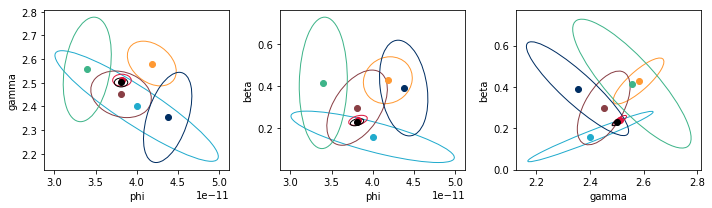

In [4]:
def read_fit_result(label, color):
    filename = f'../results/fit/gammapy/{label}/fit_results_logparabola.yaml'
    data = yaml.load(open(filename))
    mean = [_['value'] for _ in data['parameters']]
    cov = data['covariance']
    # Use parameter names that are consistent with the paper
    names = ["phi", "reference", "gamma", "beta"]
    # names = [_['name'] for _ in data['parameters']]
    mn = MultiNorm(mean, cov, names)
    # Drop the fixed "reference" parameter
    mn = mn.marginal(['phi', 'gamma', 'beta'])

    mn.label = label
    mn.color = color
    
    return mn

class FitResults:
    def __init__(self):
        self.results = {
            "fermi": read_fit_result('fermi', '#21ABCD'),
            "magic": read_fit_result('magic', '#FF9933'),
            "veritas": read_fit_result('veritas', '#893F45'),
            "fact": read_fit_result('fact', '#3EB489'),
            "hess": read_fit_result('hess', '#002E63'),
            "joint": read_fit_result('joint', 'crimson'),
        }
    
        mn = MultiNorm.joint(list(self.results.values()))
        mn.color = 'black'
        self.results['joint2'] = mn

def plot_panel(results, names, ax):
    for label, result in results.results.items():
#         result = results.results[label]
        mn = result.marginal(names)
        ellipse = mn.to_matplotlib_ellipse(
            fc='none',
            ec=result.color,
            label=label,
        )
        ax.add_patch(ellipse)
        x = mn.mean[0]
        y = mn.mean[1]
        ax.plot(x, y, 'o', color=result.color)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])

def plot_results(results):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    plot_panel(results, ['phi', 'gamma'], axes[0])
    plot_panel(results, ['phi', 'beta'], axes[1])
    plot_panel(results, ['gamma', 'beta'], axes[2])
    fig.tight_layout()
#     fig.legend()

results = FitResults()
plot_results(results)

In [5]:
print(results.results['joint'])

MultiNorm(n=3)
names: ['phi', 'gamma', 'beta']
mean: [3.82210828e-11 2.51063136e+00 2.38427939e-01]
err: [1.13294166e-12 2.56902681e-02 2.38268652e-02]
cov:
[[ 1.28355682e-24 -2.18676781e-16  1.06295373e-14]
 [-2.18676781e-16  6.59989875e-04  4.90472013e-04]
 [ 1.06295373e-14  4.90472013e-04  5.67719506e-04]]


In [6]:
print(results.results['joint2'])

MultiNorm(n=3)
names: ['phi', 'gamma', 'beta']
mean: [3.81066641e-11 2.50125814e+00 2.29727438e-01]
err: [8.15032403e-13 1.87640463e-02 1.71917955e-02]
cov:
[[ 6.64277817e-25 -5.62806833e-17  5.33837498e-15]
 [-5.62806833e-17  3.52089433e-04  2.62454228e-04]
 [ 5.33837498e-15  2.62454228e-04  2.95557831e-04]]
